In [3]:
# Standard Library Imports
import os
import sys
import timeit
from scipy.optimize import least_squares

# Optimize performance by setting environment variables
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'
from timeit import repeat

# Third-party Library Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal, uniform
from tensorflow.keras.models import load_model
from itertools import product
from numba import jit

# Local Module Imports
sys.path.append('./data/')
import tinyDA as tda

from model import Model_DR
# from utils import *

case = "FOM"  # Options: "2-step"/"1-step"/"FOM"

# MCMC Parameters
noise        = 0.01
scaling      = 0.05
scaling1     = 1
scaling2     = 1
scaling3     = 1
n_iter       = 1100
burnin       = 100
thin         = 1
sub_sampling = [5,5]

# Initialize Parameters
n_samples = 25
np.random.seed(123)



# Instantiate Models for Different Resolutions
solver_h1 = Model_DR(n=128, dt=0.05, L=20., T=50.05)
solver_h2 = Model_DR(n=64,  dt=0.1,  L=20., T=50.05)
solver_h3 = Model_DR(n=32,  dt=0.2,  L=20., T=50.05)
solver_h4 = Model_DR(n=16,  dt=0.5,  L=20., T=50.05)

# Define Points for Data Extraction
x_data = y_data = 1.25*np.arange(start=-2,stop=2.1)
datapoints = np.array(list(product(x_data, y_data)))
print(datapoints)

# Solver Data Functions

def solver_data(solver, x, lag=1):
    """
    Run the solver and extract data for given coordinates.

    Parameters:
    solver : Model_DR instance
        The solver object to run.
    x : array-like
        Input parameter for the solver.

    Returns:
    np.ndarray
        Array of (u, v) data for specified points.
    """
    # Run the solver once with the given parameters
    solver.solve(x[0], x[1])

    # Use the updated get_data method to retrieve data in one call
    return solver.get_data(datapoints, lag)

def model_HF(input): return solver_data(solver_h1, input).flatten()
def model_LF1(input): return solver_data(solver_h2, input).flatten()
def model_LF2(input): return solver_data(solver_h3, input).flatten()
def model_LF3(input): return solver_data(solver_h4, input).flatten()

d1_range = [0.01,0.1]
beta_range = [0.5,1.5]

d1_scale = d1_range[1] - d1_range[0]
beta_scale = beta_range[1] - beta_range[0]

class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = (self.upper_bound[0] - self.lower_bound[0])*(self.upper_bound[1] - self.lower_bound[1])
    
    def pdf(self, x):
        if (self.lower_bound[0] <= x[0] <= self.upper_bound[0]) and (self.lower_bound[1] <= x[1] <= self.upper_bound[1]):
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if self.pdf(x) == 0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)
    

x_distribution = CustomUniform([0.01,0.5],[0.1,1.5])

Times, Time_ESS, ESS, samples_tot, ERR = [], [], [], [], []

x_true = x_distribution.rvs()   
print(x_true)

y_true = solver_data(solver_h4, x_true).flatten()
y_lf = model_LF3(x_true).flatten()

print(np.linalg.norm(y_true-y_lf)/np.linalg.norm(y_lf))

y_observed = y_true + np.random.normal(scale=noise, size=y_true.shape[0])
    

if case != "FOM":
    print(f"\nMSE coarse simulation 1 test:  {np.sqrt(np.mean((model_1(x_true) - y_true)**2)):.4e}")
    print(f"\nMSE coarse simulation 2 test:  {np.sqrt(np.mean((model_2(x_true) - y_true)**2)):.4e}")
    print(f"\nMSE coarse simulation 3 test:  {np.sqrt(np.mean((model_3(x_true) - y_true)**2)):.4e}")
    print(f"\nMSE coarse simulation HF test:  {np.sqrt(np.mean((model_HF(x_true) - y_values[sample])**2)):.4e}")
    
def ls(x):
    return (y_observed-model_LF3(x))

res = least_squares(ls,[0.05,0.7], jac='2-point', verbose=2, bounds=([0.01,0.5],[0.1,1.5]))
covariance = np.linalg.inv(res.jac.T @ res.jac)
covariance *= 1/np.max(np.abs(covariance))
print("Covariance: ", covariance)
print("Params: ", res.x)



[[-2.5  -2.5 ]
 [-2.5  -1.25]
 [-2.5   0.  ]
 [-2.5   1.25]
 [-2.5   2.5 ]
 [-1.25 -2.5 ]
 [-1.25 -1.25]
 [-1.25  0.  ]
 [-1.25  1.25]
 [-1.25  2.5 ]
 [ 0.   -2.5 ]
 [ 0.   -1.25]
 [ 0.    0.  ]
 [ 0.    1.25]
 [ 0.    2.5 ]
 [ 1.25 -2.5 ]
 [ 1.25 -1.25]
 [ 1.25  0.  ]
 [ 1.25  1.25]
 [ 1.25  2.5 ]
 [ 2.5  -2.5 ]
 [ 2.5  -1.25]
 [ 2.5   0.  ]
 [ 2.5   1.25]
 [ 2.5   2.5 ]]
[0.07268223 0.78613933]
0.0
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6029e+03                                    1.68e+04    
       1              2         2.2639e+03      3.39e+02       1.40e-02       2.65e+04    
       2              3         1.4786e+03      7.85e+02       2.30e-02       3.29e+04    
       3              4         4.6703e+02      1.01e+03       2.80e-02       2.35e+04    
       4              5         2.7430e+01      4.40e+02       1.97e-02       6.48e+03    
       5              6         1.3898e+00      2.

In [4]:
cov_likelihood = noise**2 * np.eye(y_true.shape[0])
y_distribution_1 = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*scaling1)
y_distribution_2 = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*scaling2)
y_distribution_3 = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*scaling3)
y_distribution_fine = tda.GaussianLogLike(y_observed, cov_likelihood)
my_proposal = tda.GaussianRandomWalk(C=covariance,scaling=1e-4, adaptive=True, gamma=1.1, period=10)


my_posteriors = [
    tda.Posterior(x_distribution, y_distribution_1, model_1), 
    tda.Posterior(x_distribution, y_distribution_2, model_2),
    tda.Posterior(x_distribution, y_distribution_3, model_3)
] if case != "FOM" else tda.Posterior(x_distribution, y_distribution_fine, model_LF3)


start_time = timeit.default_timer()
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1,
                    initial_parameters=res.x, subchain_length=sub_sampling,
                    adaptive_error_model='state-independent',store_coarse_chain=False)
elapsed_time = timeit.default_timer() - start_time

Sampling chain 1/1


Running chain, α = 0.21: 100%|██████████| 1100/1100 [05:03<00:00,  3.63it/s]


/u/zacchei/miniconda3/envs/eccomas/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


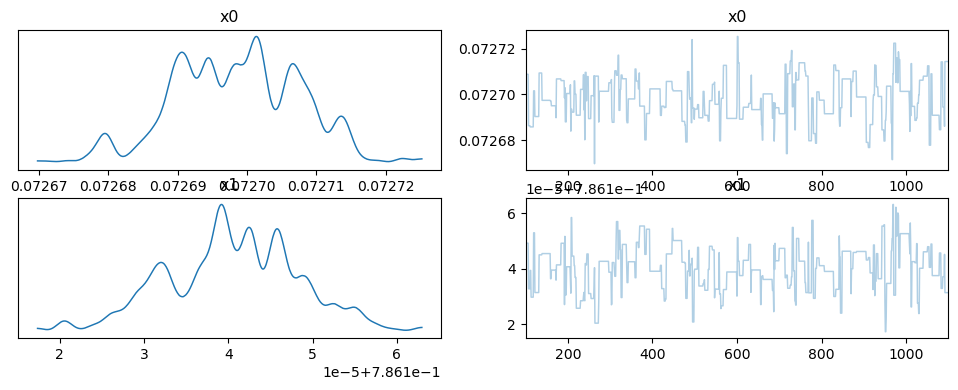

In [5]:
idata = tda.to_inference_data(samples, level=2).sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
mean_ess = np.mean([ess.data_vars[f'x{j}'].values for j in range(2)])
az.plot_trace(idata)
plt.savefig('trace')